# Mason's workbook on zestimate log errors

##### Due: 2022.01.07

In [1]:
#learn gong fu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mason_functions as mf
import scaler as sc
import wrangle_bits as wb
import sklearn.preprocessing

import env
import os
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE

## Plan

## Wrangle

In [2]:
#define my sql query
sql = '''
SELECT *
FROM properties_2017
LEFT JOIN predictions_2017 pred USING(parcelid)
LEFT JOIN airconditioningtype USING(airconditioningtypeid)
LEFT JOIN architecturalstyletype USING(architecturalstyletypeid)
LEFT JOIN buildingclasstype USING(buildingclasstypeid)
LEFT JOIN heatingorsystemtype USING(heatingorsystemtypeid)
LEFT JOIN propertylandusetype USING(propertylandusetypeid)
LEFT JOIN storytype USING(storytypeid)
LEFT JOIN typeconstructiontype USING(typeconstructiontypeid)
WHERE latitude IS NOT NULL 
AND longitude IS NOT NULL
AND propertylandusetypeid = 261
AND transactiondate LIKE "2017%%"
AND pred.id IN (SELECT MAX(id)
FROM predictions_2017
GROUP BY parcelid
HAVING MAX(transactiondate))
'''

#define my url
url = mf.get_db_url('zillow')

#set up an if-conditional to see if there is a .csv readily available, then load the data
if os.path.isfile('zillow_ol_pal.csv'):
    df = pd.read_csv('zillow_ol_pal.csv', index_col = 0)
else:
    df = pd.read_sql(sql, url)
    df.to_csv('zillow_ol_pal.csv')

In [3]:
pd.options.display.max_columns = 69
pd.options.display.max_rows = 69

In [4]:
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14297519,1727539,NaN,3.5,4.0,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,1.0,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,NaN,NaN,261.0,NaN,NaN,NaN,NaN,17052889,1387261,NaN,1.0,2.0,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,1,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,NaN,NaN,261.0,NaN,NaN,NaN,NaN,14186244,11677,NaN,2.0,3.0,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,2,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,NaN,NaN,261.0,2.0,NaN,NaN,NaN,12177905,2288172,NaN,3.0,4.0,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,NaN,NaN,261.0,2.0,NaN,NaN,1.0,12095076,781532,NaN,3.0,4.0,9.0,3.0,NaN,NaN,2962.0,2962.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,34145202.0,-118179824.0,63000.0,1.0,NaN,NaN,NaN,1.0,0101,PSR2,6.037461e+07,47019.0,3101.0,274684.0,96293.0,0.0,NaN,1.0,NaN,NaN,1950.0,NaN,NaN,276684.0,773303.0,2016.0,496619.0,9516.26,NaN,NaN,6.037461e+13,6,-0.001011,2017-01-01,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52319 entries, 0 to 52318
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        76 non-null     float64
 1   storytypeid                   47 non-null     float64
 2   propertylandusetypeid         52319 non-null  float64
 3   heatingorsystemtypeid         33849 non-null  float64
 4   buildingclasstypeid           0 non-null      float64
 5   architecturalstyletypeid      70 non-null     float64
 6   airconditioningtypeid         13615 non-null  float64
 7   parcelid                      52319 non-null  int64  
 8   id                            52319 non-null  int64  
 9   basementsqft                  47 non-null     float64
 10  bathroomcnt                   52319 non-null  float64
 11  bedroomcnt                    52319 non-null  float64
 12  buildingqualitytypeid         33654 non-null  float64
 13  c

In [6]:
#verify length of dataframe is the same as the number of unique parcel ids
df.parcelid.nunique()

52319

In [7]:
#calculate column nulls
column_nulls = wb.calculate_column_nulls(df)

In [8]:
#column nulls at a glance
column_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
finishedsquarefeet13,52319,1.00000,100.0%
buildingclassdesc,52319,1.00000,100.0%
buildingclasstypeid,52319,1.00000,100.0%
finishedsquarefeet15,52319,1.00000,100.0%
storydesc,52272,0.99910,99.91%
storytypeid,52272,0.99910,99.91%
basementsqft,52272,0.99910,99.91%
yardbuildingsqft26,52256,0.99880,99.88%
architecturalstyletypeid,52249,0.99866,99.87%
architecturalstyledesc,52249,0.99866,99.87%


In [9]:
#calculate row nulls
row_nulls = wb.calculate_row_nulls(df)

In [10]:
#row nulls at a glance
row_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
28006,48,0.69565,70%
8954,48,0.69565,70%
41347,47,0.68116,68%
13356,46,0.66667,67%
21989,45,0.65217,65%
...,...,...,...
44684,24,0.34783,35%
83,24,0.34783,35%
37444,24,0.34783,35%
39391,23,0.33333,33%


In [11]:
#handle missing nulls 
#(drop any column with over half of the values missing and any rows with over half missing after dropping columns)
df = wb.handle_nulls(df, .5 , .5)

In [12]:
#calculate remaining column nulls
column_nulls = wb.calculate_column_nulls(df)

In [13]:
#remaining column nulls at a glance
column_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
buildingqualitytypeid,18665,0.35675,35.68%
unitcnt,18558,0.35471,35.47%
propertyzoningdesc,18558,0.35471,35.47%
heatingorsystemdesc,18470,0.35303,35.3%
heatingorsystemtypeid,18470,0.35303,35.3%
regionidcity,1036,0.01980,1.98%
lotsizesquarefeet,366,0.00700,0.7%
finishedsquarefeet12,246,0.00470,0.47%
fullbathcnt,135,0.00258,0.26%
calculatedbathnbr,135,0.00258,0.26%


In [14]:
#calculate remaining row nulls
row_nulls = wb.calculate_row_nulls(df)

In [15]:
#remaining row nulls at a glance
row_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
28006,14,0.40000,40%
8954,14,0.40000,40%
41347,13,0.37143,37%
48475,12,0.34286,34%
32311,12,0.34286,34%
...,...,...,...
21482,0,0.00000,0%
21483,0,0.00000,0%
21484,0,0.00000,0%
21486,0,0.00000,0%


In [16]:
#set an empty list
okay_to_drop = []

#commence loop through index of column nulls
for n in range(len(column_nulls)):
    
    #set up conditional to see if ratio of values missing in column is less than 2%
    if column_nulls.iloc[n].null_ratio < .2:
        
        #add features to list 
        okay_to_drop.append(column_nulls.index[n])
        
#verify
#print(okay_to_drop)

#commence loop through list        
for feature in okay_to_drop:
    
    #drop rows where there are missing values in the columns specified
    df = df[df[feature].notnull()]

In [17]:
#calculate remaining nulls
column_nulls = wb.calculate_column_nulls(df)

In [18]:
#pull up the list of column nulls to verify dropped rows
column_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
buildingqualitytypeid,17939,0.35481,35.48%
propertyzoningdesc,17873,0.35351,35.35%
unitcnt,17856,0.35317,35.32%
heatingorsystemdesc,17764,0.35135,35.14%
heatingorsystemtypeid,17764,0.35135,35.14%
propertylandusetypeid,0,0.00000,0.0%
taxvaluedollarcnt,0,0.00000,0.0%
roomcnt,0,0.00000,0.0%
yearbuilt,0,0.00000,0.0%
structuretaxvaluedollarcnt,0,0.00000,0.0%


What is propertyzoningdesc? There is no corresponding table

In [19]:
#pull up values for propertyzoningdesc column
df.propertyzoningdesc.value_counts(dropna = False)

NaN         17873
LAR1         6404
LARS         1378
LBR1N        1107
SCUR2         611
            ...  
RMPD            1
LCR17500        1
CMR2YY          1
MOPD*           1
AZR1*           1
Name: propertyzoningdesc, Length: 1237, dtype: int64

In [20]:
#create final list of columns to drop
final_drops = []

In [21]:
#add column to list
final_drops.append('propertyzoningdesc')

In [22]:
#pull up values for heatingsystemdesc
df.heatingorsystemdesc.value_counts(dropna = False)

Central       19897
NaN           17764
Floor/Wall    12330
Forced air      502
Solar            36
None             16
Baseboard         7
Radiant           4
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64

Okay, I'll come back for this

In [23]:
#pull up values for unitcnt
df.unitcnt.value_counts(dropna = False)

1.0    32684
NaN    17856
2.0       18
3.0        1
Name: unitcnt, dtype: int64

In [24]:
#map null values to the value of 1
df.unitcnt = df.unitcnt.map({np.nan: 1,
               1: 1,
               2: 2,
               3: 3})

In [25]:
#verify
df.unitcnt.value_counts(dropna = False)

1    50540
2       18
3        1
Name: unitcnt, dtype: int64

In [26]:
#pull up values for buildingqualitytypeid
df.buildingqualitytypeid.value_counts(dropna = False).sort_index(ascending = False)

12.0       76
11.0      482
10.0      211
9.0      1035
8.0      7981
7.0      3125
6.0     10125
5.0      1469
4.0      7967
3.0       141
2.0         4
1.0         4
NaN     17939
Name: buildingqualitytypeid, dtype: int64

There is nothing in the database that I see that helps me identify what kind of feature this is. Drop

In [27]:
#add to the list of final drops
final_drops.append('buildingqualitytypeid')

In [28]:
#drop columns on list
df = df.drop(columns = final_drops)

In [29]:
#calculate remaining column nulls
column_nulls = wb.calculate_column_nulls(df)

In [30]:
#a look at what's left
column_nulls.sort_values('nulls', ascending = False)

,nulls,null_ratio,null_percentage
heatingorsystemtypeid,17764,0.35135,35.14%
heatingorsystemdesc,17764,0.35135,35.14%
assessmentyear,0,0.00000,0.0%
regionidzip,0,0.00000,0.0%
roomcnt,0,0.00000,0.0%
unitcnt,0,0.00000,0.0%
yearbuilt,0,0.00000,0.0%
structuretaxvaluedollarcnt,0,0.00000,0.0%
taxvaluedollarcnt,0,0.00000,0.0%
propertylandusetypeid,0,0.00000,0.0%


In [31]:
len(column_nulls)

33

In [32]:
#drop nulls for now
df = df[df.heatingorsystemtypeid.notnull()]
df = df[df.heatingorsystemdesc.notnull()]

In [33]:
#value counts for heatingorsystemtypeid
df.heatingorsystemtypeid.value_counts(dropna = False).sort_index()

1.0         7
2.0     19897
6.0       502
7.0     12330
10.0        2
13.0       16
18.0        4
20.0       36
24.0        1
Name: heatingorsystemtypeid, dtype: int64

In [34]:
#get rid of value that only has 1 count (corresponding value for type id 24 is 'Yes')
df = df[df.heatingorsystemtypeid != 24]

In [35]:
#import feature selection functions
import explore_bits as eb

In [36]:
df.head()

,propertylandusetypeid,heatingorsystemtypeid,parcelid,id,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,id.1,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc
3,261.0,2.0,12177905,2288172,3.0,4.0,3.0,2376.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,0101,6.037300e+07,396551.0,3101.0,96330.0,0.0,1,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,3,-0.103410,2017-01-01,Central,Single Family Residential
4,261.0,2.0,12095076,781532,3.0,4.0,3.0,2962.0,2962.0,6037.0,3.0,34145202.0,-118179824.0,63000.0,0101,6.037461e+07,47019.0,3101.0,96293.0,0.0,1,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,6,-0.001011,2017-01-01,Central,Single Family Residential
6,261.0,2.0,12790562,1246926,3.0,4.0,3.0,3039.0,3039.0,6037.0,3.0,33960230.0,-118006914.0,20028.0,0100,6.037500e+07,14634.0,3101.0,96173.0,0.0,1,1970.0,177527.0,220583.0,2016.0,43056.0,3104.19,6.037500e+13,8,-0.040966,2017-01-02,Central,Single Family Residential
7,261.0,2.0,11104527,1639362,3.0,4.0,3.0,2540.0,2540.0,6037.0,3.0,34434971.0,-118464390.0,10384.0,0101,6.037920e+07,54311.0,3101.0,96374.0,0.0,1,1999.0,271715.0,430108.0,2016.0,158393.0,6103.36,6.037920e+13,10,0.005963,2017-01-02,Central,Single Family Residential
11,261.0,7.0,11830315,571930,1.0,2.0,1.0,1146.0,1146.0,6037.0,1.0,34024040.0,-118159090.0,4657.0,0100,6.037532e+07,17882.0,3101.0,96003.0,0.0,1,1939.0,127960.0,273745.0,2016.0,145785.0,3739.02,6.037532e+13,18,-0.035085,2017-01-02,Floor/Wall,Single Family Residential


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32794 entries, 3 to 52318
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         32794 non-null  float64
 1   heatingorsystemtypeid         32794 non-null  float64
 2   parcelid                      32794 non-null  int64  
 3   id                            32794 non-null  int64  
 4   bathroomcnt                   32794 non-null  float64
 5   bedroomcnt                    32794 non-null  float64
 6   calculatedbathnbr             32794 non-null  float64
 7   calculatedfinishedsquarefeet  32794 non-null  float64
 8   finishedsquarefeet12          32794 non-null  float64
 9   fips                          32794 non-null  float64
 10  fullbathcnt                   32794 non-null  float64
 11  latitude                      32794 non-null  float64
 12  longitude                     32794 non-null  float64
 13  l

In [38]:
df.propertycountylandusecode.value_counts()

0100    25479
0101     6135
122       555
0104      355
0103       84
010G       65
0108       52
010M       41
0113        6
0110        5
0109        5
0102        3
0105        2
0111        2
1           1
0131        1
0114        1
0130        1
0133        1
Name: propertycountylandusecode, dtype: int64

In [39]:
df['age'] = 2017 - df['yearbuilt']

In [40]:
quick_drop = ['assessmentyear', 'yearbuilt', 'transactiondate', 'heatingorsystemdesc', 'propertylandusedesc', 'propertycountylandusecode', 'id', 'regionidcounty', 'regionidcity', 'regionidzip', 'regionidzip', 'logerror', 'censustractandblock', 'rawcensustractandblock', 'id.1', 'finishedsquarefeet12', 'latitude', 'longitude', 'fips']
df = df.drop(columns = quick_drop)

In [41]:
df = df.set_index('parcelid')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32794 entries, 12177905 to 12826780
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         32794 non-null  float64
 1   heatingorsystemtypeid         32794 non-null  float64
 2   bathroomcnt                   32794 non-null  float64
 3   bedroomcnt                    32794 non-null  float64
 4   calculatedbathnbr             32794 non-null  float64
 5   calculatedfinishedsquarefeet  32794 non-null  float64
 6   fullbathcnt                   32794 non-null  float64
 7   lotsizesquarefeet             32794 non-null  float64
 8   roomcnt                       32794 non-null  float64
 9   unitcnt                       32794 non-null  int64  
 10  structuretaxvaluedollarcnt    32794 non-null  float64
 11  taxvaluedollarcnt             32794 non-null  float64
 12  landtaxvaluedollarcnt         32794 non-null  floa

In [43]:
df_columns = df.columns.to_list()

In [44]:
for col in df_columns:

    q1, q3 = df[col].quantile([.25, .75])  # get quartiles
    
    iqr = q3 - q1   # calculate interquartile range
    
    upper_bound = q3 + 1.8 * iqr   # get upper bound
    lower_bound = q1 - 1.8 * iqr   # get lower bound
    
    dft = df[(df[col] > lower_bound) & (df[col] < upper_bound)] # return dataframe without outliers

In [45]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31740 entries, 12177905 to 12826780
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         31740 non-null  float64
 1   heatingorsystemtypeid         31740 non-null  float64
 2   bathroomcnt                   31740 non-null  float64
 3   bedroomcnt                    31740 non-null  float64
 4   calculatedbathnbr             31740 non-null  float64
 5   calculatedfinishedsquarefeet  31740 non-null  float64
 6   fullbathcnt                   31740 non-null  float64
 7   lotsizesquarefeet             31740 non-null  float64
 8   roomcnt                       31740 non-null  float64
 9   unitcnt                       31740 non-null  int64  
 10  structuretaxvaluedollarcnt    31740 non-null  float64
 11  taxvaluedollarcnt             31740 non-null  float64
 12  landtaxvaluedollarcnt         31740 non-null  floa

In [46]:
df = dft

In [47]:
quant_vars = ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'unitcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'lotsizesquarefeet', 'roomcnt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'age']

In [48]:
len(quant_vars)

13

In [49]:
#split it
train, validate, test = wb.split_data(df, target = 'heatingorsystemtypeid')

In [50]:
#scale the data
train_scaled, validate_scaled, test_scaled, scaler = sc.robust_scaler(train, validate, test, quant_vars)

In [51]:
#set up modeling data
X_train = train_scaled
y_train = train.heatingorsystemtypeid

X_validate = validate_scaled
y_validate = validate.heatingorsystemtypeid

X_test = test_scaled
y_test = test.heatingorsystemtypeid

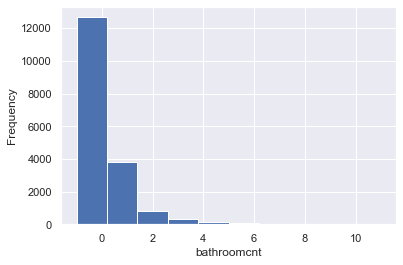

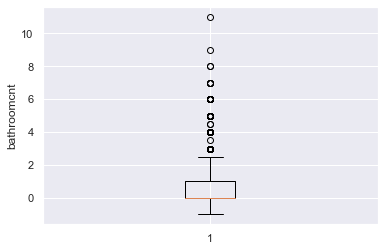

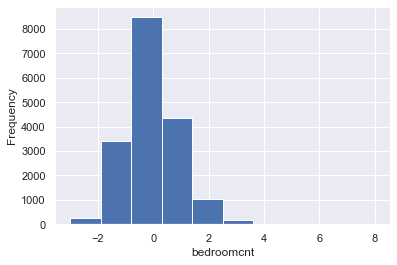

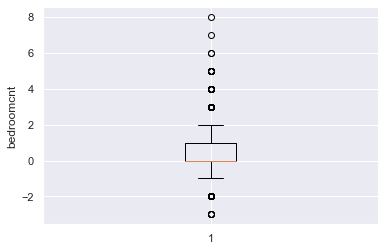

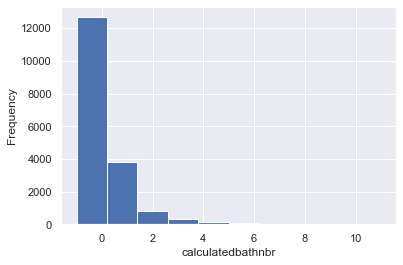

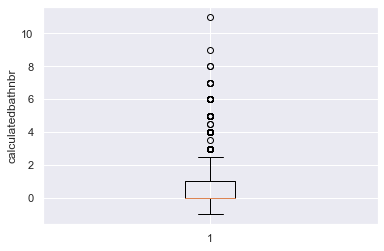

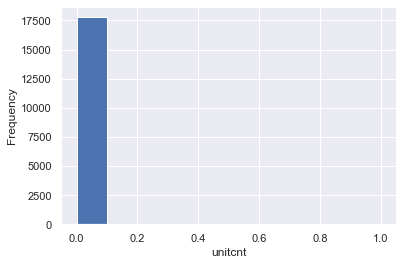

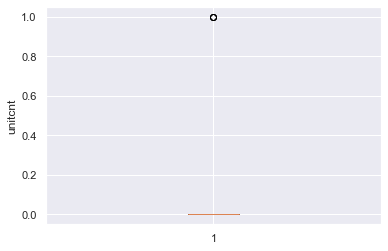

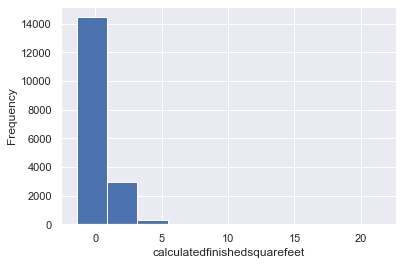

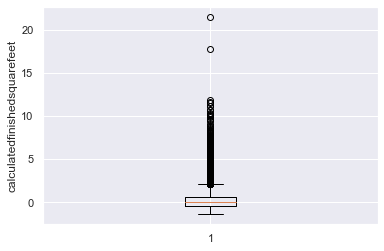

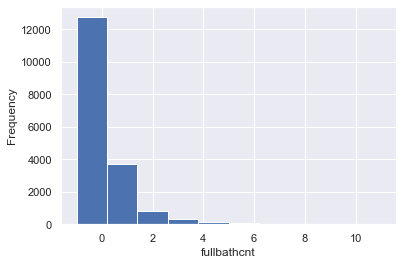

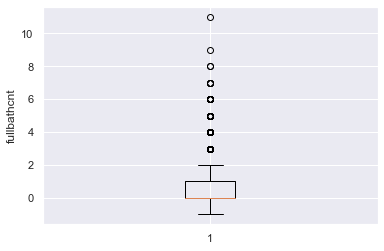

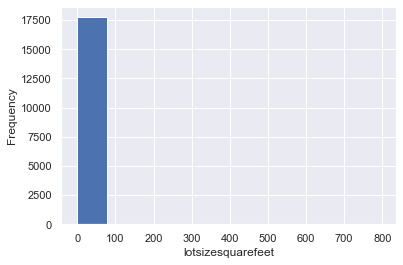

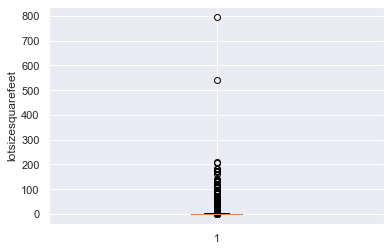

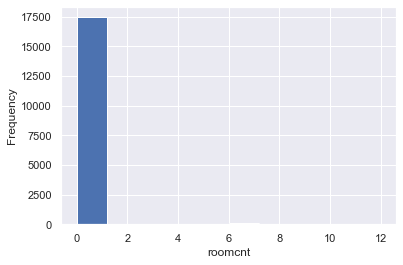

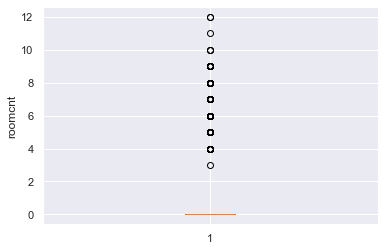

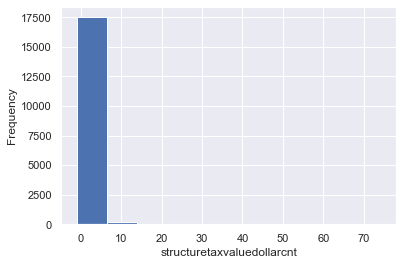

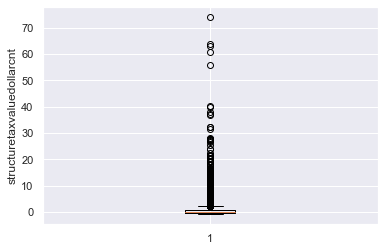

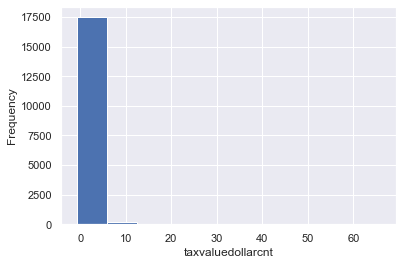

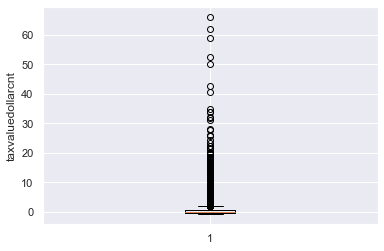

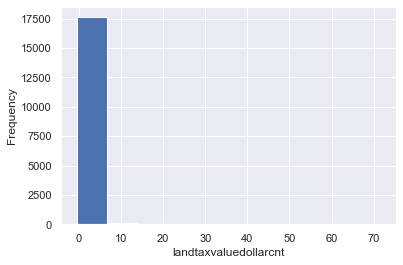

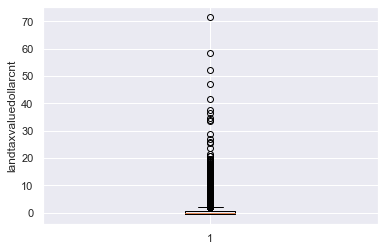

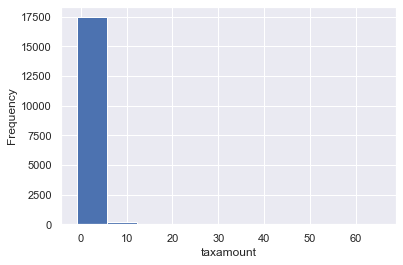

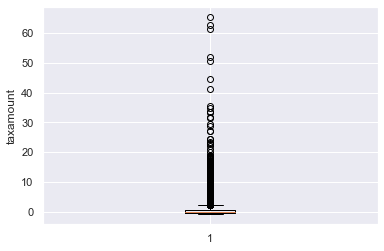

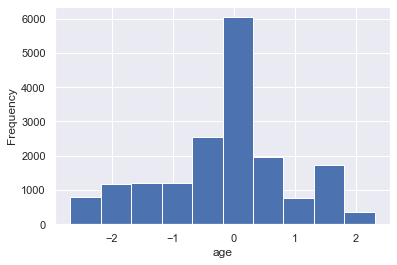

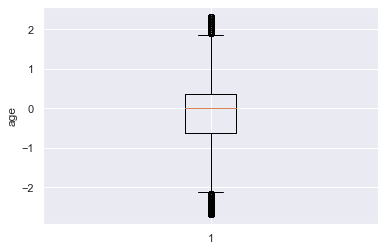

In [52]:
#get list
train_columns = train_scaled.columns.to_list()

#loop through this list
for cat in quant_vars:
    train_scaled[cat].hist()
    plt.xlabel(cat)
    plt.ylabel('Frequency')
    plt.show();
    plt.boxplot(train_scaled[cat])
    plt.ylabel(cat)
    plt.show();

In [53]:
best_features = eb.select_kbest(X_train, y_train, 10)
best_features

['bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'age']

In [54]:
best_rfe = eb.rfe(X_train, y_train, 10)
best_rfe

['bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'unitcnt',
 'calculatedfinishedsquarefeet',
 'roomcnt',
 'structuretaxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'age']

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
len(X_train)

17774

In [58]:
len(y_train)

17774

In [59]:
#create
rf = RandomForestClassifier(bootstrap = True,
                            min_samples_leaf = 3,
                            max_depth = 5,
                            random_state = 421)

#fit
rf.fit(X_train[best_features], y_train)

#predict
train_scaled['predictions'] = rf.predict(X_train[best_features])

In [60]:
train_scaled.predictions.value_counts()

2.0    10964
7.0     6781
6.0       29
Name: predictions, dtype: int64